## Procesamiento del Lenguaje Natural 1
### Carrera de Especialización en Inteligencia Artificial - FIUBA

## Desafío N° 3
### Predicción de próxima palabra

### 2º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |


### Objetivo
El objetivo es entrenar un modelo de lenguaje basado en arquitectura de redes recurrentes a partir de un corpus de texto. En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la perplejidad. Parte del ejercicio consiste en estructurar adecuadamente el dataset para este problema.

### 0. Librerías

In [1]:
import numpy as np                  # for data manipulation
import pandas as pd                 # for data manipulation
import matplotlib.pyplot as plt     # for data visualization

import nltk

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### 1. Dataset

In [2]:
nltk.download("gutenberg")
from nltk.corpus import gutenberg

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\badesia\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [3]:
file_ids = gutenberg.fileids()
print("Cantidad de archivos: ", len(file_ids))
print(file_ids)

Cantidad de archivos:  18
['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


Elegimos trabajar con Hamlet de Shakespeare.

In [4]:
text = gutenberg.raw('shakespeare-hamlet.txt')
with open('hamlet.txt','w') as file:
    file.write(text)               # Guardamos el corpus

In [5]:
text_lower = text.lower()                   # Quitamos las mayúsculas

### 2. Tokenización

Aplicamos el tokenizador de keras para convertir el texto en una secuencia de palabras.

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer=Tokenizer()
tokenizer.fit_on_texts([text])
total_words=len(tokenizer.word_index) + 1

print("Cantidad de palabras: ", total_words)

Cantidad de palabras:  4818


In [7]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'to': 3,
 'of': 4,
 'i': 5,
 'you': 6,
 'a': 7,
 'my': 8,
 'it': 9,
 'in': 10,
 'that': 11,
 'ham': 12,
 'is': 13,
 'not': 14,
 'his': 15,
 'this': 16,
 'with': 17,
 'your': 18,
 'but': 19,
 'for': 20,
 'me': 21,
 'lord': 22,
 'as': 23,
 'what': 24,
 'he': 25,
 'be': 26,
 'so': 27,
 'him': 28,
 'haue': 29,
 'king': 30,
 'will': 31,
 'no': 32,
 'our': 33,
 'we': 34,
 'on': 35,
 'are': 36,
 'if': 37,
 'all': 38,
 'then': 39,
 'shall': 40,
 'by': 41,
 'thou': 42,
 'come': 43,
 'or': 44,
 'hamlet': 45,
 'good': 46,
 'do': 47,
 'hor': 48,
 'her': 49,
 'let': 50,
 'now': 51,
 'thy': 52,
 'how': 53,
 'more': 54,
 'they': 55,
 'from': 56,
 'enter': 57,
 'at': 58,
 'was': 59,
 'oh': 60,
 'like': 61,
 'most': 62,
 'there': 63,
 'well': 64,
 'know': 65,
 'selfe': 66,
 'would': 67,
 'them': 68,
 'loue': 69,
 'may': 70,
 "'tis": 71,
 'vs': 72,
 'sir': 73,
 'qu': 74,
 'which': 75,
 'did': 76,
 'why': 77,
 'laer': 78,
 'giue': 79,
 'thee': 80,
 'ile': 81,
 'must': 82,
 'hath': 

### 3. Generación de secuencias de n-gramas

Guardamos la secuencia de tokens en el texto. Esto debería ayudar al modelo a entender relaciones entre las palabras.

In [8]:
input_sequences = []
ngram_by_sentence = []
for line in text.split('\n'):
    token_list=tokenizer.texts_to_sequences([line])[0]
    for i in range(1,len(token_list)):
        n_gram_sequence=token_list[:i+1]
        input_sequences.append(n_gram_sequence)
        ngram_by_sentence.append(len(n_gram_sequence))


In [22]:
input_sequences = []
ngram_by_sentence = []
for line in text.split('\n'):
    token_list=tokenizer.texts_to_sequences([line])[0]
    if len(token_list) > 0:
        input_sequences.append(token_list)
        ngram_by_sentence.append(len(token_list))

In [27]:
input_sequences[:5]

[[1, 687, 4, 45, 41, 1886, 1887, 1888],
 [1180, 1889, 1890, 1891],
 [57, 407, 2, 1181, 177, 1892],
 [407, 1182, 63],
 [408, 162, 377, 21, 247, 882]]

In [28]:
ngram_by_sentence[:5]

[8, 4, 6, 3, 6]

In [29]:
max_sequence_length=max([len(x) for x in input_sequences])
print('La máxima secuencia de tokens en el texto es: ', max_sequence_length)

La máxima secuencia de tokens en el texto es:  14


Veamos su histograma de distribución

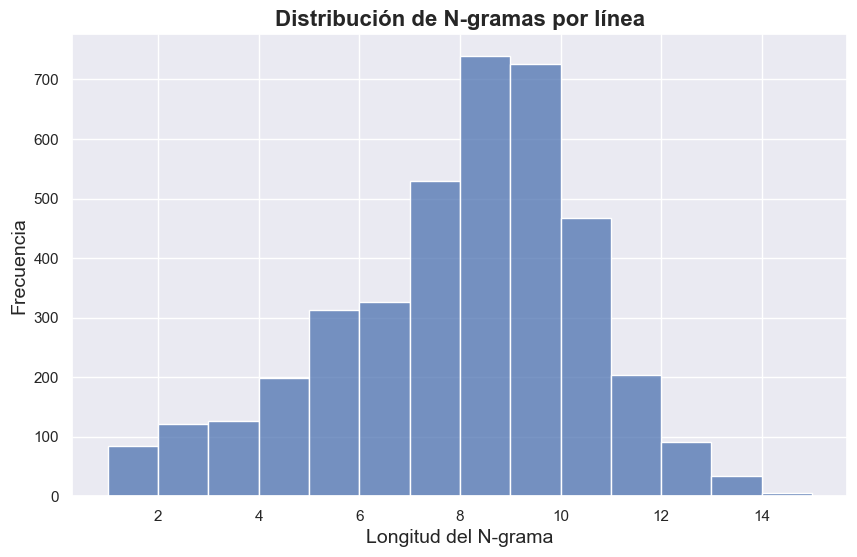

In [31]:
import seaborn as sns

# Configurar el estilo de Seaborn
sns.set(style='darkgrid')

# Crear el histograma
plt.figure(figsize=(10,6))
sns.histplot(ngram_by_sentence, bins=range(1, max(ngram_by_sentence)+2), kde=False)

# Añadir títulos y etiquetas
plt.title('Distribución de N-gramas por línea', fontsize=16, fontweight='bold')
plt.xlabel('Longitud del N-grama', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

# Mostrar el histograma
plt.show()

Definimos el tamaño máximo de contexto:

In [ ]:
max_context_size = int(np.percentile(ngram_by_sentence, 90)-1)  # Restamos 1 porque el último token será el target
print(f'max_context_size: {max_context_size}')

max_context_size: 9


### 4. Train/Validation/Test split

In [38]:
from sklearn.model_selection import train_test_split

# Definimos fracciones para train/validation/test
val_size = 0.20
test_size = 0.20
train_size = 1 - (val_size + test_size)

rnd_seed = 42
# Generamos los sets
sequences_train_val, sequences_test, _, _, = train_test_split(input_sequences,
                                                input_sequences,
                                                test_size = test_size,
                                                random_state = rnd_seed)

sequences_train, sequences_val, _, _, = train_test_split(sequences_train_val,
                                                        sequences_train_val,
                                                        test_size = val_size / (train_size + val_size),
                                                        random_state = rnd_seed)

# Calculamos la cantidad de elementos de cada set
ntrain = len(sequences_train)
nval = len(sequences_val)
ntest = len(sequences_test)

print("Dimension del set de train:", ntrain)
print("Dimension del set de validation:", nval)
print("Dimension del set de test:", ntest)
print("")
print(f"Fracción de datos de train: {train_size:.2f}")
print(f"Fracción de datos de validation: {val_size:.2f}")
print(f"Fracción de datos de test: {test_size:.2f}")

Dimension del set de train: 2379
Dimension del set de validation: 793
Dimension del set de test: 794

Fracción de datos de train: 0.60
Fracción de datos de validation: 0.20
Fracción de datos de test: 0.20


Sobre el set de entrenamiento, adicionalmente, spliteamos las líneas que tienen mayor tamaño al contexto máximo definido y hacemos data augmentation generando secuencias más pequeñas.

In [64]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences_train_augm = []

for seq in sequences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  extra_seq = []
  if len(seq) > (max_context_size+1):
    extra = len(seq)-(max_context_size+1) + 1
    for i in range(extra):
      extra_seq.append(seq[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
      extra_seq.append(seq)
  
  for seq in extra_seq:
    subseq = [seq[:i+2] for i in range(len(seq)-1)]                                               # Generamos todas las sub-secuencias
    sequences_train_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))      # Paddeamos al tamaño de contexto máximo

sequences_train_augm = np.concatenate(sequences_train_augm, axis=0)
ntrain_augm = len(sequences_train_augm) 
print("Dimension del set de train:", ntrain_augm)
print(f"Incremento del set de training: x{ntrain_augm / ntrain:.2f}")

Dimension del set de train: 17982
Incremento del set de training: x7.56


In [65]:
sequences_train_augm[:10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,  38,  70],
       [  0,   0,   0,   0,   0,   0,   0,  38,  70,  26],
       [  0,   0,   0,   0,   0,   0,  38,  70,  26,  64],
       [  0,   0,   0,   0,   0,   0,   0,   0,   2,  39],
       [  0,   0,   0,   0,   0,   0,   0,   2,  39,  55],
       [  0,   0,   0,   0,   0,   0,   2,  39,  55,  94],
       [  0,   0,   0,   0,   0,   2,  39,  55,  94,  32],
       [  0,   0,   0,   0,   2,  39,  55,  94,  32, 263],
       [  0,   0,   0,   2,  39,  55,  94,  32, 263, 132],
       [  0,   0,   2,  39,  55,  94,  32, 263, 132, 386]])

In [66]:
sequences_train_augm.shape

(17982, 10)

In [67]:
X_train = sequences_train_augm[:,:-1]
y_train = sequences_train_augm[:,-1]

### 5. Modelo #1

In [75]:
from types import SimpleNamespace

cfg = SimpleNamespace(**{})

In [76]:
cfg.embedding_dim = 300
cfg.dropout = 0.2

model = Sequential()
model.add(Embedding(input_dim =total_words + 1, output_dim = cfg.embedding_dim, input_shape=(max_context_size,)))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(cfg.dropout))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(total_words + 1, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

model.summary()

c:\Users\badesia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 9, 300)         │     1,445,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 9, 64)          │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4819)           │       159,027 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,733,271 (6.61 MB)

 Trainable params: 1,733,271 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    '''

    def __init__(self, val_data):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])
        self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

        self.info.append((count,count+len_seq))
        count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        print(f'\n mean perplexity: {np.mean(scores)} \n')

In [ ]:
history = model.fit(X_train,y_train, epochs=50, verbose=1)

In [ ]:
def predict_next_word(model,tokenizer,text,max_sequence_length):
  token_list=tokenizer.texts_to_sequences([text])[0]
  if len(token_list)>=max_sequence_length:
    token_list=token_list[-(max_sequence_length):]
  token_list=pad_sequences([token_list],maxlen=max_sequence_length-1,padding='pre')
  predicted=model.predict(token_list,verbose=0)
  predicted_word_index=np.argmax(predicted,axis=1)
  for word,index in tokenizer.word_index.items():
    if index==predicted_word_index:
      return word
  return None

In [ ]:
# save the model
model.save('next_word_prediction_model.h5')
# save tokenizer
import pickle
with open('tokenizer.pkl','wb') as handle:
  pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
input_text="Taken to"
print(f"Input text: {input_text}")
max_sequence_length=model.input_shape[1]+1
next_word=predict_next_word(model,tokenizer,input_text,max_sequence_length)
print(f"Next word: {next_word}")

https://github.com/Vishwaaaah/Next_word_prediction_using_LSTM/blob/main/Next_word_prediction.ipynb

https://vishwasbhadoria.medium.com/lstm-for-beginners-a-fun-next-word-prediction-project-to-boost-your-resume-93d14ccc1f3e